<a href="https://colab.research.google.com/github/superorangeman/STA-260-Project/blob/main/STA_260_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Load Modules**

In [ ]:
pip install --upgrade pip

In [ ]:
pip install numpy pandas opencv-python rpy2 openpyxl matplotlib gitpython requests scikit-image scikit-learn statsmodels

In [3]:
%%capture

# import modules
import gzip, os

import numpy as np
import pandas as pd

# from google.colab import data_table
from os import walk
from glob import glob


In [ ]:
load_ext rpy2.ipython

#### **Download and Unpack Files Using**

In [ ]:
# #%%capture
# #uncomment cell for

# %%R

# h = install.packages("pacman")
# h = library(pacman)
# p_load("tidyverse", "googledrive")

# #downloading data

# drive_deauth()
# drive_user()
# public_file = drive_get(as_id("17TsDWM-Ug8mQuSqEp-6zn_W1raMdNgiV"))
# drive_download(public_file, overwrite = T)

#### **Unzipping File**

In [17]:
%%capture

# if on google colab
# !unzip "/content/Linke_Data_shared.zip" -d "/content/"

!unzip "Linke_Data_shared.zip"
not_reading = glob("Linke_Data_shared/*.txt")
if os.path.exists(not_reading[0]):
  os.remove(not_reading[0])
else:
  print("Can not delete the file as it doesn't exists")

#### **Data Preprocessing**

In [18]:
def extract_excel(file):
    """
    file: filepath to excel file
    entry_dict: dataframe of values extracted from excel file and the file metadata
    """
    profilometer_xlsx = pd.read_excel(io = file, sheet_name=1, header=None)
    entry_dict = {}
    for row in profilometer_xlsx.iloc[0:23,0]:
        val_vec = [item for item in row.split(" ") if item != ''][0:2]

        try:
            entry_dict[val_vec[0]] = [float(val_vec[1])]
        except:
            entry_dict[val_vec[0]] = [float("nan")] # For those with errors, set to NaN

    entry_dict  = pd.DataFrame.from_dict(entry_dict)
    meta_data_df = profilometer_metadata_namer(file)
    entry_dict = meta_data_df.join(entry_dict)
    return(entry_dict)

In [19]:
def extract_txt(file):
    """
    file: filepath to txt file
    entry_dict: dataframe of values extracted from excel file and the file metadata
    """
    profilometer_txt = pd.read_table(file)
    entry_dict = {}
    for pos,val in enumerate(profilometer_txt.iloc[16:39,0]):
        val_vec = [item for item in val.split(";") if item != ''][0:2]
        if pos == 12: # fixing double occurence of Rmr(c)
          val_vec[0] += "2"

        try:
            entry_dict[val_vec[0]] = [float(val_vec[1])]
        except:
            entry_dict[val_vec[0]] = [float("nan")]

    #     print(entry_dict[val_vec[0]])    
    entry_dict  = pd.DataFrame.from_dict(entry_dict)
    meta_data_df = profilometer_metadata_namer(file)
    entry_dict = meta_data_df.join(entry_dict)
    return(entry_dict)

In [20]:
def profilometer_metadata_namer(file):
    """
    file: filepath
    meta_data_df: dataframe for
    """
    file_id = file.split("/")[-1].split(".")[0].split("_")
    file_snap_time = file.split("/")[1].split("_")[0]
    if file_snap_time == "INTERMEDIATE":
        if file_id[0] == "01":
          file_id[0] = "0"
        meta_data_df = pd.DataFrame({"Capturetime": file_snap_time, "Buildangle":[file_id[0]], "Facenumber": [file_id[1]], "Measurementnum": [file_id[2]]})
    else:
        meta_data_df = pd.DataFrame({"Capturetime": file_snap_time, "Buildangle":[file.split("/")[-2].split("_")[0]], "Facenumber": [file_id[0]], "Measurementnum": [file_id[1]]})
    return(meta_data_df)

In [ ]:
# folders = ["INITIAL_PROFILOMETER_READINGS", "INTERMEDIATE_PROFILOMETER_READINGS", "POST_PROFILOMETER_READINGS"]

prof_filenames = glob("Linke_Data_shared/**/*.TXT", recursive=True) + glob("Linke_Data_shared/**/*.xlsx", recursive=True)
print("{} TXT and XLSX files matched".format(len(prof_filenames)))
img_profilometer_data =[]
processed = 0
alternates = 0
pd_file = []
for pos,file in enumerate(prof_filenames):

  if "Alternate" in file: # ignoring profilometer filenames that has alternate
    alternates += 1
    continue
  if ".TXT" in file:
    profile_readings = extract_txt(file)
    profile_readings.rename(columns={"Rku": "Rkmu", "Rmr(c)": "Rmr(c)1"}, inplace=True)
    processed += 1
  else:
    profile_readings = extract_excel(file)
    profile_readings.rename(columns={"Rkµ": "Rkmu"}, inplace=True)
    processed += 1
  if pos > 0:
    img_profilometer_data = pd.concat([img_profilometer_data,profile_readings])
  else: 
    img_profilometer_data = profile_readings
  pd_file.append(file)
  if ((pos+1) % 20  == 0 or pos == len(prof_filenames) - 1):
    print("Processed {0} out of {1} profilometer readings. File id: {2}".format(processed, len(prof_filenames), file.split("/")[-1]))
img_profilometer_data["ProfileFilepath"] =  pd_file   
print()
print()
print("Finished processing all {} profilometer readings excluding {} alternates".format(processed, alternates))

In [ ]:
img_filenames = glob("Linke_Data_shared/**/*.jpg", recursive=True)
print("{} JPG images matched".format(len(prof_filenames)))
magnif, buildangle, facenumber, file_snap_times, filepaths = [], [], [], [], []
for pos,img_file in enumerate(img_filenames):
  if ((pos+1) % 10  == 0 or pos == len(img_filenames) - 1):
    print("Processing {0} out of {1} Grinding tool image. Filepath: {2}".format(pos + 1, len(img_filenames), img_file))
  file_snap_time = img_file.split("/")[1].split("_")[0].upper()
  try:
    if file_snap_time == "INITIAL":
      file_id = img_file.split("/")[-1].split(".")[0].split("_")
      if "A" in file_id[1]: # ignoring images that are alternate
            continue
      else:
          facenumber.append(file_id[1])
      buildangle.append(file_id[0])
      magnif.append(img_file.split("/")[1].split("_")[-1][:-1]) 
      filepaths.append(img_file)
      file_snap_times.append(file_snap_time)
    elif  file_snap_time == "INTERMEDIATE":
      file_id = img_file.split("/")[-1].split(".")[0].split("_")
      if "A" in file_id[1]: # ignoring images that are alternate
            continue
      else:
          facenumber.append(file_id[1])    
      magnif.append(file_id[3])
      buildangle.append(file_id[2])
      filepaths.append(img_file)
      file_snap_times.append(file_snap_time)       
    elif  file_snap_time == "POST":
      file_id = img_file.split("/")[-1].split(".")[0].split("_")
      if "A" in file_id[1]: # ignoring images that are alternate
            continue
      else:
          facenumber.append(file_id[1])
      magnif.append(file_id[2])
      buildangle.append(file_id[0])
      filepaths.append(img_file)
      file_snap_times.append(file_snap_time)
    else:
      print("Error: Bad file: {}".format(img_file))
  except:
      print("Something went wrong while processing file: {}".format(img_file))
    
print("\n\n\nFinished processing all files")
img_metadata = pd.DataFrame({"Capturetime": file_snap_times, "Buildangle":buildangle, "Facenumber": facenumber, "Zoom": magnif, "ImgFilepath": filepaths})
print(img_metadata.shape)

In [23]:
# Aggregate profilometer reading for each image per image
def aggregate_by_img(df):
    agg_arg = {}
    col_names = df.columns[3:]
    for col in col_names:
        agg_arg[col] = 'mean'
        if col == 'Measurementnum' :
           agg_arg[col] = "count"
        if col == "ProfileFilepath":
           agg_arg[col] = "first"       

    df_agg = df.groupby(["Capturetime", "Buildangle", "Facenumber"]).agg(agg_arg)
    print('Aggregated dataframe from {} to {}'.format(df.shape, df_agg.shape))
    return df_agg

In [ ]:

display(img_metadata.head())
print(img_metadata.shape)

display(img_profilometer_data.head())
print(img_profilometer_data.shape)

In [ ]:
# creating aggregated dataset

img_profilometer_data_agg = aggregate_by_img(img_profilometer_data)

display(img_profilometer_data_agg.head())
print(img_profilometer_data_agg.shape)

In [ ]:
# merging profilometer aggregated dataset with corresponding images. One reading per image

grinding_img_dataset = pd.merge(left = img_profilometer_data, right = img_metadata, how = "inner", on= ["Capturetime", 'Buildangle','Facenumber'], indicator = True)

grinding_img_agg_dataset = pd.merge(left = img_profilometer_data_agg, right = img_metadata, how = "inner", on= ["Capturetime", 'Buildangle','Facenumber'], indicator = True)
# grinding_img_agg_dataset = grinding_img_agg_dataset.dropna()
display(grinding_img_dataset)
print(grinding_img_dataset.shape)


display(grinding_img_agg_dataset)
print(grinding_img_agg_dataset.shape)

#### **Load Sample Image**

In [55]:
from matplotlib import pyplot as plt
from cv2 import imread

(960, 1280, 3)


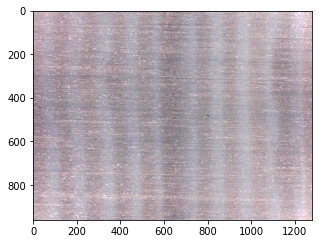

In [56]:
img_test = imread(grinding_img_dataset.loc[:,"ImgFilepath"][5])
plt.figure(figsize=(5,5))
print(img_test.shape)
plt.imshow(img_test)

In [57]:
grinding_img_dataset.columns

Index(['Capturetime', 'Buildangle', 'Facenumber', 'Measurementnum', 'Ra', 'Rq',
       'Rz', 'Rp', 'Rv', 'Rsk', 'Rkmu', 'Rc', 'RSm', 'RDq', 'Rmr', 'Rmr(c)1',
       'Rmr(c)2', 'Rdc', 'Rt', 'Rz1max', 'Rk', 'Rpk', 'Rvk', 'Mr1', 'Mr2',
       'A1', 'A2', 'ProfileFilepath', 'Zoom', 'ImgFilepath', '_merge'],
      dtype='object')

In [58]:
import requests
import re

def getFilename_fromCd(cd):
    """
    Get filename from content-disposition
    """
    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    if len(fname) == 0:
        return None
    return fname[0]

glcm_master = "GLCM-master.zip"
if os.path.exists(glcm_master):
    print("GLCM already exist exists")
else:
    url = 'https://github.com/tzm030329/GLCM/archive/refs/heads/master.zip'
    r = requests.get(url, allow_redirects=True)
    filename = getFilename_fromCd(r.headers.get('content-disposition'))
    print(filename)
    open(filename, 'wb').write(r.content)
    !unzip GLCM-master.zip 
    !cp GLCM-master/fast_glcm.py fast_glcm.py

# !git clone https://github.com/tzm030329/GLCM.git
# !cp /content/GLCM/fast_glcm.py fast_glcm.py
 


GLCM already exist exists


#### **Prepare Dataset**

In [31]:
# generate design matrix

def generate_design_matrix(df, resol = False, response_var = "Ra"):
    
    if resol == 200 or resol == 50:
        df = df[df["Zoom"] == str(resol)]
        
    df = df.loc[:,[response_var,"ImgFilepath"]]
    dataset = pd.DataFrame()
    for pos, file in enumerate(df["ImgFilepath"]):
        if ((pos+1) % 10  == 0 or pos == len(file) - 1):
            print("Processing {0} out of {1} Grinding tool image. Filepath: {2}".format(pos + 1, df.shape[0], file))  
        if pos == 0:
            dataset = feature_extractor(file)
        else:
            f_df = feature_extractor(file)
            dataset = pd.concat([dataset,f_df], axis=0)
    print("Processed all image file and generated design matrix")
    return (df[response_var], dataset)


In [32]:
# Increasing dataset from 90 samples to 12 * 90 by splitting images into 12

def img_splitter(file, num_slice_height, num_slice_width): # height = row, width = col
    img = imread(file)
    (img_height, img_width, num_channels) = img.shape
    height_coord = [ii * img_height//num_slice_height for ii in range(0, num_slice_height + 1)] # generate the cutting point for the img. 
    width_coord = [ii * img_width//num_slice_width for ii in range(0, num_slice_width + 1)]
    sliced_img_dict = {}
    indx = 1
    
    for ii in range(len(height_coord)): 
        if ii == len(height_coord)-1: # dont try index index out of range
            continue
        for jj  in range(len(width_coord)):
            if jj == len(width_coord)-1:
                continue
            else:
                sliced_img_dict[indx] = img[ height_coord[ii]:height_coord[ii+1], width_coord[jj]:width_coord[jj+1], : ]
                indx += 1
    return(sliced_img_dict) 


# match splitted image to response. if the measurement number is less than the
# number of images, y is repeated until the dimension matches

def img_splitter_response_matcher(df, response_var, file, num_slice_height = 3, num_slice_width = 4):

    new_df = df[df["ImgFilepath"] == file]
    splitted_imgs = img_splitter(file, num_slice_height, num_slice_width)
    res_unrolled = np.resize(new_df[response_var], num_slice_height * num_slice_width)
    for pos in range(num_slice_height * num_slice_width):
        if pos == 0:
            dataset = GLCM_feature_extractor(splitted_imgs[pos+1], "file")
        else:
            f_df = GLCM_feature_extractor(splitted_imgs[pos], "file")
            dataset = pd.concat([dataset,f_df], axis=0)
    return (res_unrolled, dataset)
    
    
# generate design matrix after splitting    
    
def generate_design_matrix_using_img_split(df, num_slice_height = 3, num_slice_width = 4, response_var = "Ra"):
        
    df = df.loc[:,[response_var,"ImgFilepath"]]
    dataset = pd.DataFrame()
    df1 = df.loc[:,["ImgFilepath"]] # isolating only file names so we can select unique one for loop
    df1.drop_duplicates(subset=["ImgFilepath"], inplace = True)   
    targets = []
    for pos, file in enumerate(df1["ImgFilepath"]):
        if ((pos+1) % 10  == 0 or pos == len(file) - 1):
            print("Processing {0} out of {1} Grinding tool image. Filepath: {2}".format(pos + 1, df1.shape[0], file))  
        if pos == 0:
            res, dataset = img_splitter_response_matcher(df, response_var, file)
        else:
            res, f_df = img_splitter_response_matcher(df, response_var, file)
            dataset = pd.concat([dataset,f_df], axis=0)
        targets.extend(res)
    print("Processed all image file and generated design matrix")
    targets = pd.DataFrame({"y": targets})
    return (targets["y"], dataset)


            


#### **GLCM Feature Extraction**

In [35]:
# importing GLCM modules
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

In [266]:
# GLCM extractor

def GLCM_feature_extractor(img, imgOrFile = "image"):
        
    df = pd.DataFrame()
    if imgOrFile == "image":
        img = imread(img)
    else:
        pass
        
    img = np.resize(img, (img.shape[0], img.shape[0]))
    distance_list = [[1], [3], [5], [1], [1], [1]]
    #distance_list = [[1],[1],[1],[1]]
    # angle_list  =[[0], [np.pi/2],[np.pi/4],[np.pi *3/4] ]
    angle_list = [[0],[0],[0], [np.pi/4], [np.pi/2], [np.pi*3/4]]
    #glcm_features = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast', 'ASM']
    #use a subset of glcm features
    glcm_features = ['energy', 'correlation','dissimilarity', 'homogeneity', 'contrast']

    for pos, val in enumerate(zip(distance_list, angle_list)):
        distance, angle = val[0], val[1]
        for feature in glcm_features:
            GLCM = greycomatrix(img, distance, angle)  
            GLCM_feature = greycoprops(GLCM, feature)[0]
            feature = feature.title() + str(pos)
            df[feature] = GLCM_feature
            entropy = shannon_entropy(img)
        df['Entropy'+ str(pos)] = entropy
            
    return df    

In [267]:
# y,X = generate_design_matrix(df = grinding_img_dataset, resol = False, img_crop_dim = False)
y,X = generate_design_matrix_using_img_split(df = grinding_img_agg_dataset, num_slice_height = 3, num_slice_width = 4, response_var = "Ra")

Processing 10 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/0_5.jpg
Processing 20 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/15_4.jpg
Processing 30 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INITIAL_3D printed_Photos_200X/90_3.jpg
Processing 40 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/2_4_0_200.jpg
Processing 50 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/1_2_90_50.jpg
Processing 51 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/2_3_90_50.jpg
Processing 52 out of 90 Grinding tool image. Filepath: Linke_Data_shared/INTERMEDIATE_PHOTOS/2_3_90_200.jpg
Processing 60 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/0_3_200.jpg
Processing 70 out of 90 Grinding tool image. Filepath: Linke_Data_shared/Post_Test_Photos/15_2_200.jpg
Processing 80 out of 90 Grin

In [268]:
# Making sure shapes are right
print(X.shape)
print(y.shape)

(1080, 36)
(1080,)


In [ ]:
plt.plot(y)

In [ ]:
y[:].value_counts()

In [ ]:
# Plotting extracted features

for i, col in enumerate(X.columns):
    fig=plt.figure(i)
    plt.plot(y, X[col])
    plt.title(col)

plt.show()

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import random
from sklearn.utils import shuffle


In [273]:
# Data set comes in two Zoom level with the same output.
# Select in such a way that if X50 in in test, then X200 is also in test to avoid data leaking

def get_index(y, frac = 0.7):
    all_indx = [i for i in range(0,len(y))]
    even_indx = [i for i in range(0,len(y)-1,2)]
    frac_indx = round(len(even_indx) * frac)

    train_indx = random.sample(even_indx, frac_indx)
    train_indx = train_indx + [ i+1 for i in train_indx]
    test_indx = np.delete(all_indx, train_indx)
    return train_indx, test_indx



In [274]:
# Remove columns with the same number
# if column has the same number then SD is 0
# y = y[y<40]
# X = X[y<40]
print(X.shape)
cols = X.select_dtypes([np.number]).columns
std = X[cols].std()
cols_to_drop = std[std==0].index
X = X.drop(cols_to_drop, axis=1)
print(cols_to_drop)
print(X.shape)
print(len(y))

(1080, 36)
Index([], dtype='object')
(1080, 36)
1080


#### **Principal Component Regression & Partial Least Squares**

In [275]:
random_state = random.sample([i for i in range(0,100)], 1)[0]
random_state

17

In [276]:


train_indx, test_indx = get_index(y, frac = 0.7)
X_train, y_train = X.iloc[train_indx], y.iloc[train_indx]
X_test, y_test = X.iloc[test_indx], y.iloc[test_indx]

X_train, y_train = shuffle(X_train, y_train, random_state= random_state)

X_test, y_test = shuffle(X_test, y_test, random_state = random_state)


pcr = make_pipeline(StandardScaler(), PCA(), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression()
pls.fit(X_train, y_train)


PLSRegression()

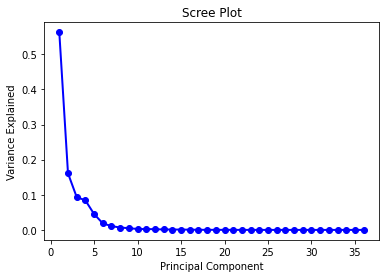

In [277]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [278]:
# y_new = y[y<40]
# X_new = X[y<40]
# print(len(y_new))
# print(X.shape)

In [285]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.572
PLS r-squared 0.539


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


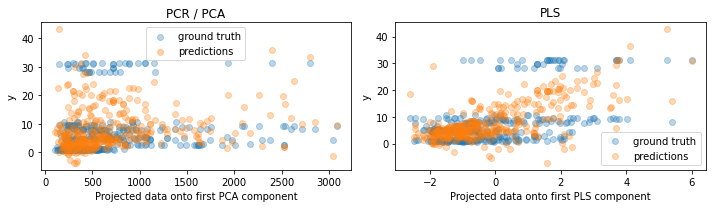

PCR r-squared 0.572
PLS r-squared 0.539


In [286]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test)[:,0], pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test)[:,0], pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()


print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

In [292]:
n_components = 10


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

X_test, y_test = shuffle(X_test, y_test, random_state=random_state)


pcr = make_pipeline(StandardScaler(), PCA(), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components)
pls.fit(X_train, y_train)

print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.572
PLS r-squared 0.539


In [265]:
# from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Gradient boosted trees 
from sklearn.ensemble import GradientBoostingRegressor

GBregr = GradientBoostingRegressor()


In [54]:
# Random forest


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 4)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


from sklearn.ensemble import RandomForestRegressor
RFregr = RandomForestRegressor()

RFregr = RandomizedSearchCV(estimator = RFregr, param_distributions = random_grid, n_iter = 100,
                               cv = 5, verbose=0, random_state=random_state, n_jobs = -1)

RFregr.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
y_pred = RFregr.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

In [140]:
y_pred = pcr.predict(X_test)
y_pred 

print(mean_squared_error(y_test, y_pred))

array([ 2.830837  ,  3.99089052,  5.2197191 ,  3.96435385,  1.86544144,
       -0.76997099,  2.90070827,  1.80655988,  3.61288863,  2.93605144,
        5.30531858,  1.76844001,  5.58630068,  2.95201969,  1.30958995,
        1.38370139,  3.98048862,  3.60799562,  1.24345954,  1.16367795,
        1.46494507,  2.10037481,  2.15259843,  0.7548012 ,  2.65953593,
        3.93287297,  4.870315  ,  1.7772271 ,  3.17119359, -0.08357077,
        4.05101356,  1.90350122,  1.9838014 ,  2.77565167,  3.29487873,
        1.68551258,  1.26509113,  3.97010442,  4.66175073,  4.53713175,
        5.34454016,  1.41814529,  2.57903843,  4.08493068,  1.43227645,
        0.82941627,  0.8998557 ,  3.32889802,  4.92085928,  1.32250583,
        1.00441924,  4.18281233,  2.64824538,  1.71868771,  3.21248626,
        2.82146529,  2.40276852,  3.14441428,  0.10302431,  3.04376607,
        1.78865987,  2.42218599,  2.61242926,  1.78427417,  4.18266337,
        0.54532315,  1.84106833,  2.60754558,  3.07461524,  1.74

In [ ]:
pip install --upgrade pip

In [ ]:
XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)